In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"adityamunagala","key":"0c876f34b72b2247deb7fb26ae97be9b"}'}

In [2]:
!mkdir ~/.kaggle/

In [3]:
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c dogs-vs-cats

100% 810M/812M [00:28<00:00, 27.5MB/s]
100% 812M/812M [00:28<00:00, 29.5MB/s]


In [5]:
!unzip -qq dogs-vs-cats.zip

In [6]:
!unzip -qq train.zip

In [7]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_1")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2000)

In [8]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)


In [9]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                        

In [10]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [11]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [12]:
from tensorflow import keras
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch1.x",
        save_best_only=True,
        monitor="val_loss"
    )
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
63/63 [==============================] - 168s 3s/step - loss: 0.6985 - accuracy: 0.5030 - val_loss: 0.6924 - val_accuracy: 0.5160
Epoch 2/10
63/63 [==============================] - 191s 3s/step - loss: 0.6961 - accuracy: 0.5185 - val_loss: 0.6856 - val_accuracy: 0.6300
Epoch 3/10
63/63 [==============================] - 161s 3s/step - loss: 0.6913 - accuracy: 0.5580 - val_loss: 0.6768 - val_accuracy: 0.5560
Epoch 4/10
63/63 [==============================] - 181s 3s/step - loss: 0.6617 - accuracy: 0.6060 - val_loss: 0.6251 - val_accuracy: 0.6440
Epoch 5/10
63/63 [==============================] - 181s 3s/step - loss: 0.6182 - accuracy: 0.6515 - val_loss: 0.7889 - val_accuracy: 0.5620
Epoch 6/10
63/63 [==============================] - 161s 3s/step - loss: 0.5904 - accuracy: 0.6915 - val_loss: 0.6178 - val_accuracy: 0.6480
Epoch 7/10
63/63 [==============================] - 156s 2s/step - loss: 0.5599 - accuracy: 0.7050 - val_loss: 0.6965 - val_accuracy: 0.6460
Epoch 8/10
63

It can be shown that as the number of epochs increases, accuracy increases.

Accuracy=77.2% Val_acc=67.7% test accuracy=63.6%

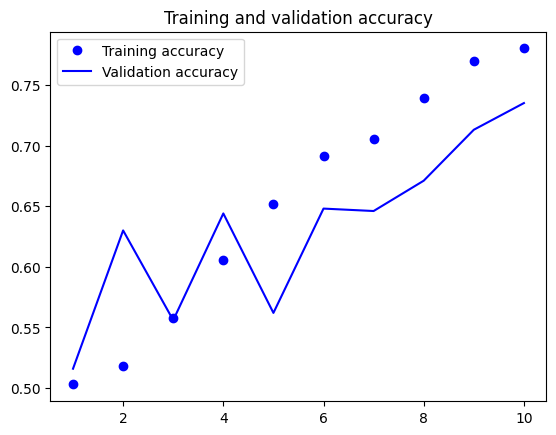

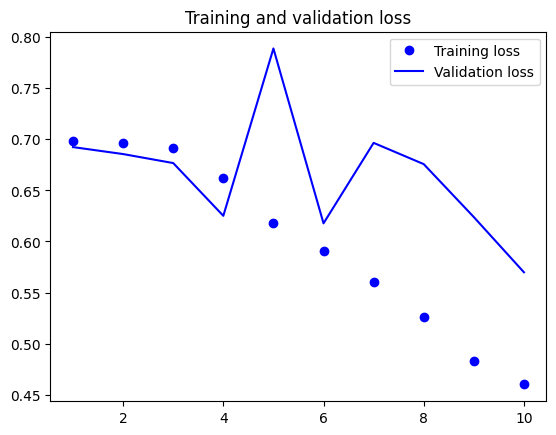

In [13]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [14]:
test_model = keras.models.load_model("convnet_from_scratch1.x")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 20s 627ms/step - loss: 0.5584 - accuracy: 0.7330
Test accuracy: 0.733


In [15]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [16]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [17]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation1.x",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
63/63 [==============================] - 185s 3s/step - loss: 0.7005 - accuracy: 0.5190 - val_loss: 0.6927 - val_accuracy: 0.5000
Epoch 2/10
63/63 [==============================] - 195s 3s/step - loss: 0.6929 - accuracy: 0.5265 - val_loss: 0.7032 - val_accuracy: 0.5000
Epoch 3/10
63/63 [==============================] - 197s 3s/step - loss: 0.6936 - accuracy: 0.5450 - val_loss: 0.6878 - val_accuracy: 0.5050
Epoch 4/10
63/63 [==============================] - 178s 3s/step - loss: 0.6956 - accuracy: 0.5430 - val_loss: 0.6946 - val_accuracy: 0.5090
Epoch 5/10
63/63 [==============================] - 194s 3s/step - loss: 0.6737 - accuracy: 0.5985 - val_loss: 0.6526 - val_accuracy: 0.6460
Epoch 6/10
63/63 [==============================] - 171s 3s/step - loss: 0.6689 - accuracy: 0.6015 - val_loss: 0.6510 - val_accuracy: 0.6020
Epoch 7/10
63/63 [==============================] - 175s 3s/step - loss: 0.6366 - accuracy: 0.6470 - val_loss: 1.1360 - val_accuracy: 0.5010
Epoch 8/10
63

In [18]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation1.x")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 19s 579ms/step - loss: 0.6203 - accuracy: 0.6740
Test accuracy: 0.674


In [19]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_2")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir, exist_ok=True)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1500)
make_subset("validation", start_index=1500, end_index=2000)
make_subset("test", start_index=2000, end_index=2500)

In [20]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 3000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [21]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [22]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch2.x",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
94/94 [==============================] - 229s 2s/step - loss: 0.6978 - accuracy: 0.5293 - val_loss: 0.6835 - val_accuracy: 0.5450
Epoch 2/10
94/94 [==============================] - 225s 2s/step - loss: 0.6782 - accuracy: 0.5913 - val_loss: 0.6605 - val_accuracy: 0.6280
Epoch 3/10
94/94 [==============================] - 225s 2s/step - loss: 0.6375 - accuracy: 0.6577 - val_loss: 0.6477 - val_accuracy: 0.6400
Epoch 4/10
94/94 [==============================] - 249s 3s/step - loss: 0.6086 - accuracy: 0.6680 - val_loss: 0.6404 - val_accuracy: 0.6220
Epoch 5/10
94/94 [==============================] - 224s 2s/step - loss: 0.5624 - accuracy: 0.7040 - val_loss: 0.7732 - val_accuracy: 0.5960
Epoch 6/10
94/94 [==============================] - 225s 2s/step - loss: 0.5234 - accuracy: 0.7410 - val_loss: 0.5908 - val_accuracy: 0.6910
Epoch 7/10
94/94 [==============================] - 223s 2s/step - loss: 0.4714 - accuracy: 0.7777 - val_loss: 0.5460 - val_accuracy: 0.7240
Epoch 8/10
94

In [23]:
test_model = keras.models.load_model(
    "convnet_from_scratch2.x")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 19s 583ms/step - loss: 0.5138 - accuracy: 0.7490
Test accuracy: 0.749


In [24]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [25]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [26]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation2.x",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)


Epoch 1/10
94/94 [==============================] - 249s 3s/step - loss: 0.6924 - accuracy: 0.5263 - val_loss: 0.7081 - val_accuracy: 0.5400
Epoch 2/10
94/94 [==============================] - 262s 3s/step - loss: 0.6800 - accuracy: 0.5670 - val_loss: 0.6654 - val_accuracy: 0.6150
Epoch 3/10
94/94 [==============================] - 239s 3s/step - loss: 0.6567 - accuracy: 0.6160 - val_loss: 0.6599 - val_accuracy: 0.6280
Epoch 4/10
94/94 [==============================] - 241s 3s/step - loss: 0.6521 - accuracy: 0.6243 - val_loss: 0.6278 - val_accuracy: 0.6620
Epoch 5/10
94/94 [==============================] - 238s 3s/step - loss: 0.6334 - accuracy: 0.6547 - val_loss: 0.6521 - val_accuracy: 0.6100
Epoch 6/10
94/94 [==============================] - 240s 3s/step - loss: 0.6209 - accuracy: 0.6590 - val_loss: 0.6373 - val_accuracy: 0.6230
Epoch 7/10
94/94 [==============================] - 246s 3s/step - loss: 0.5840 - accuracy: 0.6870 - val_loss: 0.5703 - val_accuracy: 0.6920
Epoch 8/10
94

In [27]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation2.x")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 20s 620ms/step - loss: 0.5373 - accuracy: 0.7340
Test accuracy: 0.734


In [28]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_3")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir, exist_ok=True)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1500)
make_subset("validation", start_index=1500, end_index=2500)
make_subset("test", start_index=2500, end_index=3000)


In [29]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 3000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [30]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])


In [31]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch3.x",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
94/94 [==============================] - 249s 3s/step - loss: 0.6994 - accuracy: 0.5160 - val_loss: 0.6895 - val_accuracy: 0.5220
Epoch 2/10
94/94 [==============================] - 244s 3s/step - loss: 0.6874 - accuracy: 0.5627 - val_loss: 0.7314 - val_accuracy: 0.5005
Epoch 3/10
94/94 [==============================] - 246s 3s/step - loss: 0.6567 - accuracy: 0.6133 - val_loss: 0.6334 - val_accuracy: 0.6595
Epoch 4/10
94/94 [==============================] - 246s 3s/step - loss: 0.6124 - accuracy: 0.6650 - val_loss: 0.6216 - val_accuracy: 0.6475
Epoch 5/10
94/94 [==============================] - 245s 3s/step - loss: 0.5933 - accuracy: 0.6907 - val_loss: 0.5856 - val_accuracy: 0.7010
Epoch 6/10
94/94 [==============================] - 244s 3s/step - loss: 0.5427 - accuracy: 0.7253 - val_loss: 0.6702 - val_accuracy: 0.6860
Epoch 7/10
94/94 [==============================] - 244s 3s/step - loss: 0.5017 - accuracy: 0.7550 - val_loss: 0.6098 - val_accuracy: 0.7130
Epoch 8/10
94

In [32]:
test_model = keras.models.load_model(
    "convnet_from_scratch3.x")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 20s 598ms/step - loss: 0.6104 - accuracy: 0.6740
Test accuracy: 0.674


In [33]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [34]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [35]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation3.x",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
94/94 [==============================] - 312s 3s/step - loss: 0.6944 - accuracy: 0.5037 - val_loss: 0.6940 - val_accuracy: 0.5000
Epoch 2/10
94/94 [==============================] - 264s 3s/step - loss: 0.6936 - accuracy: 0.5080 - val_loss: 0.6939 - val_accuracy: 0.5005
Epoch 3/10
94/94 [==============================] - 267s 3s/step - loss: 0.6888 - accuracy: 0.5160 - val_loss: 0.6921 - val_accuracy: 0.5960
Epoch 4/10
94/94 [==============================] - 262s 3s/step - loss: 0.6806 - accuracy: 0.5470 - val_loss: 0.6942 - val_accuracy: 0.5465
Epoch 5/10
94/94 [==============================] - 262s 3s/step - loss: 0.6643 - accuracy: 0.6027 - val_loss: 0.6617 - val_accuracy: 0.5900
Epoch 6/10
94/94 [==============================] - 263s 3s/step - loss: 0.6530 - accuracy: 0.6147 - val_loss: 0.6355 - val_accuracy: 0.6610
Epoch 7/10
94/94 [==============================] - 262s 3s/step - loss: 0.6250 - accuracy: 0.6690 - val_loss: 0.6479 - val_accuracy: 0.6190
Epoch 8/10
94

In [36]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation3.x")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 22s 643ms/step - loss: 0.6131 - accuracy: 0.6760
Test accuracy: 0.676


In [37]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))
conv_base.summary()

58889256/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                              

In [38]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

train_features.shape

1/1 [==============================] - 2s 2s/step


(3000, 5, 5, 512)

In [39]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extractionPT1.x",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=15,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/15
94/94 [==============================] - 16s 149ms/step - loss: 13.3925 - accuracy: 0.9357 - val_loss: 5.2545 - val_accuracy: 0.9625
Epoch 2/15
94/94 [==============================] - 6s 60ms/step - loss: 4.1733 - accuracy: 0.9747 - val_loss: 9.2914 - val_accuracy: 0.9585
Epoch 3/15
94/94 [==============================] - 6s 67ms/step - loss: 1.4125 - accuracy: 0.9887 - val_loss: 4.9386 - val_accuracy: 0.9710
Epoch 4/15
94/94 [==============================] - 5s 51ms/step - loss: 0.9839 - accuracy: 0.9893 - val_loss: 5.6567 - val_accuracy: 0.9755
Epoch 5/15
94/94 [==============================] - 7s 76ms/step - loss: 1.1170 - accuracy: 0.9923 - val_loss: 4.9057 - val_accuracy: 0.9760
Epoch 6/15
94/94 [==============================] - 4s 46ms/step - loss: 0.5845 - accuracy: 0.9957 - val_loss: 5.6758 - val_accuracy: 0.9765
Epoch 7/15
94/94 [==============================] - 4s 46ms/step - loss: 0.4703 - accuracy: 0.9970 - val_loss: 7.3636 - val_accuracy: 0.9695
Epoch 8/15

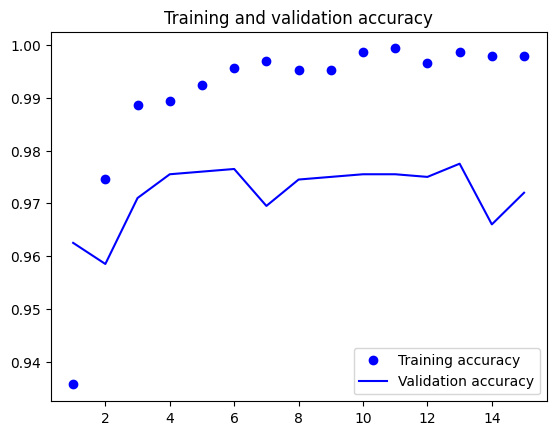

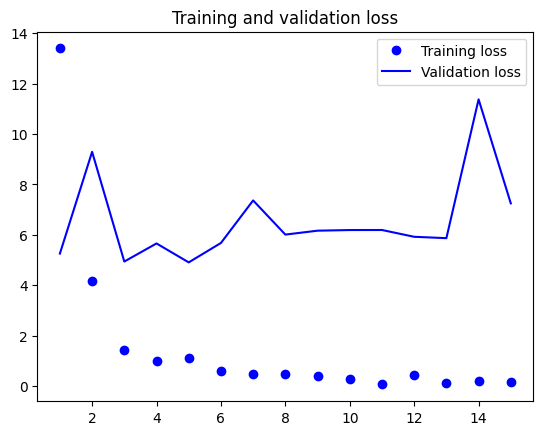

In [40]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()


In [41]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False


conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))


conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26
This is the number of trainable weights after freezing the conv base: 0


In [42]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentationPT2.x",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=5,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/5
94/94 [==============================] - 1768s 19s/step - loss: 19.0464 - accuracy: 0.9070 - val_loss: 5.1251 - val_accuracy: 0.9680
Epoch 2/5
94/94 [==============================] - 1686s 18s/step - loss: 6.5667 - accuracy: 0.9530 - val_loss: 4.1836 - val_accuracy: 0.9765
Epoch 3/5
94/94 [==============================] - 1693s 18s/step - loss: 5.9281 - accuracy: 0.9577 - val_loss: 4.6219 - val_accuracy: 0.9740
Epoch 4/5
61/94 [==================>...........] - ETA: 5:53 - loss: 4.2165 - accuracy: 0.9652